# **Part 1**

**<font color='4B7BE5'> Reinforcement learning issues need an agent that interacts with the environment and takes optimal actions that make him a goal. Lunar Lander has the role of the same environment in which learning occurs.</font>**

**<font color='orange'>Feature space</font>:** **Showdly with 2 components: horizontal position, vertical position, horizontal velocity, vertical velocity, angle, angular velocity, (time) left foot contact, right foot contact.**

**<font color='orange'>Operation space</font>: In each step, the astronaut can choose one of four actions (NO OP) or do nothing, turn on the left engine, turn the right engine turning on and turn the middle engine.</font>**

**<font color='orange'>Reward System</font>: The environment is calculated by the environment and based on the amount of fuel used, the landing position and contact time of the legs are calculated.**



In [ ]:
# install dependencies
!pip3 install gym --upgrade
!pip3 install pyglet
!pip3 install Box2D
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install gym[box2d]

In [2]:
import torch

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# enviroment
import gym

env = gym.make('LunarLander-v2')
print('State size: ', env.observation_space.shape[0])
print('action_size: ', env.action_space.n)               

State size:  8
action_size:  4


In [4]:
# Q Network
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed):

        super(QNetwork, self).__init__()   
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.out = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q_vals = self.out(x)
        return q_vals 

In [ ]:
# DQN Agent
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim


BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64      # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

class Agent():

    def __init__(self, state_size, action_size, seed):
      
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences
        
        # compute Q_target from the target network inputing next_state
        Q_target_av = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_target = rewards + gamma*(Q_target_av)*(1-dones) # broadcasting works here.
        # compute the Q_expected 
        Q_expected = self.qnetwork_local(states).gather(1, actions) # get q value for corrosponding action along dimension 1 of 64,4 matrix
        
        #apply gradient descent
        #compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward() # since we detached the Q_target, it becomes a constant and the gradients wrt Q_expected is computed only
        self.optimizer.step() # update weights
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
# experience reply
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=100)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        # Add a new experience to memory
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        # Randomly sample a batch of experiences from memory
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        # Return the current size of internal memory
        return len(self.memory)

In [ ]:
# trainig phase
agent = Agent(state_size=8, action_size=4, seed=0)

def dqn(n_episodes=500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)   # last 25 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            # env.render()
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        torch.save(agent.qnetwork_local.state_dict(), 'checkpointDQN.pth') 
        if i_episode % 25 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window), eps_start))
        if np.mean(scores_window)>=240.0:       #regret
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    return scores

# **Part 2**

**batch size: 32**

In [12]:
import time
t1 = time.time()
scores = dqn()
t2 = time.time()
print('Training time is :', (t2 - t1)/60 ,'Minutes')

Episode 25	Average Score: -176.62
Episode 50	Average Score: -157.97
Episode 75	Average Score: -135.11
Episode 100	Average Score: -115.87
Episode 125	Average Score: -84.02
Episode 150	Average Score: -61.90
Episode 175	Average Score: -54.33
Episode 200	Average Score: -48.96
Episode 225	Average Score: -52.82
Episode 250	Average Score: -50.37
Episode 275	Average Score: -50.87
Episode 300	Average Score: -51.26
Episode 325	Average Score: -43.78
Episode 350	Average Score: -38.69
Episode 375	Average Score: -12.45
Episode 400	Average Score: -0.96
Episode 425	Average Score: 26.42
Episode 450	Average Score: 28.98
Episode 475	Average Score: 30.70
Episode 500	Average Score: 35.35
Training time is : 5.852133496602376 Minutes


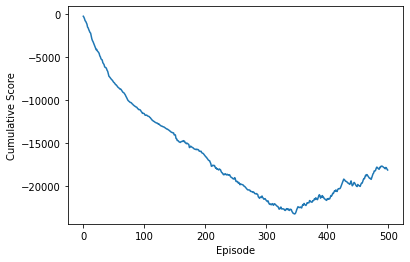

In [13]:
import pandas as pd
series = pd.Series(scores)
cumsum = series.cumsum()
# plot the scores
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(cumsum)), cumsum)
plt.ylabel('Cumulative Score')
plt.xlabel('Episode')
plt.show()

**batch size: 64**

In [ ]:
import time
t1 = time.time()
scores = dqn()
t2 = time.time()
print('Training time is :', (t2 - t1)/60 ,'Minutes')

Episode 25	Average Score: -179.90
Episode 50	Average Score: -175.09
Episode 75	Average Score: -158.68
Episode 100	Average Score: -148.52
Episode 125	Average Score: -128.45
Episode 150	Average Score: -110.58
Episode 175	Average Score: -98.41
Episode 200	Average Score: -92.10
Episode 225	Average Score: -76.20
Episode 250	Average Score: -65.26
Episode 275	Average Score: -56.26
Episode 300	Average Score: -42.16
Episode 325	Average Score: -34.73
Episode 350	Average Score: -16.83
Episode 375	Average Score: 12.20
Episode 400	Average Score: 49.87
Episode 425	Average Score: 91.49
Episode 450	Average Score: 126.53
Episode 475	Average Score: 141.93
Episode 500	Average Score: 166.29
Training time is : 10.803916215896606 Minutes


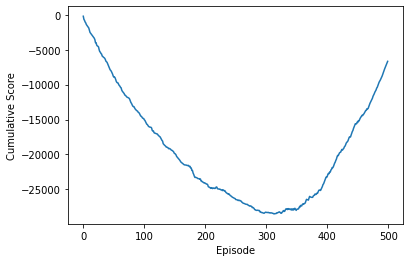

In [ ]:
import pandas as pd
series = pd.Series(scores)
cumsum = series.cumsum()
# plot the scores
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(cumsum)), cumsum)
plt.ylabel('Cumulative Score')
plt.xlabel('Episode')
plt.show()

**batch size: 128**

In [ ]:
import time
t1 = time.time()
scores = dqn()
t2 = time.time()
print('Training time is :', (t2 - t1)/60 ,'Minutes')

Episode 25	Average Score: -173.58
Episode 50	Average Score: -169.30
Episode 75	Average Score: -151.76
Episode 100	Average Score: -143.53
Episode 125	Average Score: -126.38
Episode 150	Average Score: -106.51
Episode 175	Average Score: -100.27
Episode 200	Average Score: -83.88
Episode 225	Average Score: -86.59
Episode 250	Average Score: -74.66
Episode 275	Average Score: -69.89
Episode 300	Average Score: -52.87
Episode 325	Average Score: -11.16
Episode 350	Average Score: 18.13
Episode 375	Average Score: 66.92
Episode 400	Average Score: 90.76
Episode 425	Average Score: 115.48
Episode 450	Average Score: 137.37
Episode 475	Average Score: 145.00
Episode 500	Average Score: 145.28
Training time is : 10.93846271832784 Minutes


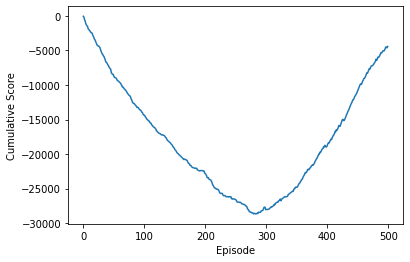

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

series = pd.Series(scores)
cumsum = series.cumsum()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(cumsum)), cumsum)
plt.ylabel('Cumulative Score')
plt.xlabel('Episode')
plt.show()

**We investigated agent performance by drawing cumulative reward in each episode for batch size = 32, 64 and 128 and the highest score was obtained with batch size = 64. In terms of convergence speed, the average rate of Batch Size= 128 is positive in Episode = 350, but in the rest of the Batch Size of Episode 375 this happens. Also, the amount of training time in Batch Size is lower than the rest, and the highest average scores occur in this Batch size.**

# **Part 3**

In [6]:
class ReplayBuffer:

    def __init__(self, state_size, action_size, buffer_size, batch_size,):

        self.states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        self.next_states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        self.actions = torch.zeros(buffer_size,1, dtype=torch.long).to(device)
        self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.e = np.zeros((buffer_size, 1), dtype=np.float)
        

        self.ptr = 0
        self.n = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size
    
    def add(self, state, action, reward, next_state, done):
       
        self.states[self.ptr] = torch.from_numpy(state).to(device)
        self.next_states[self.ptr] = torch.from_numpy(next_state).to(device)
        
        self.actions[self.ptr] = torch.from_numpy(np.asarray(action)).to(device)
        self.rewards[self.ptr] = torch.from_numpy(np.asarray(reward)).to(device)
        self.dones[self.ptr] = done
        
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.n = self.buffer_size

    def sample(self, get_all=False):
        n = len(self)
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        
        idx = np.random.choice(n, self.batch_size, replace=False)
        
        states = self.states[idx]
        next_states = self.next_states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        dones = self.dones[idx]
        
        return (states, actions, rewards, next_states, dones), idx
      
    def update_error(self, e, idx=None):
        e = torch.abs(e.detach())
        e = e / e.sum()
        if idx is not None:
            self.e[idx] = e.cpu().numpy()
        else:
            self.e[:len(self)] = e.cpu().numpy()
        
    def __len__(self):
        if self.n == 0:
            return self.ptr
        else:
            return self.n

In [7]:
class DDQNAgent():

    def __init__(self, state_size, action_size, seed=42, ddqn=True):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.ddqn = ddqn

        
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(state_size, (action_size,), BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences, idx = self.memory.sample()
                e = self.learn(experiences)
                self.memory.update_error(e, idx)
    
    def act(self, state, eps=0.):
       
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
          
    def update_error(self):
        states, actions, rewards, next_states, dones = self.memory.sample(get_all=True)
        with torch.no_grad():
            if self.ddqn:
                old_val = self.qnetwork_local(states).gather(-1, actions)
                actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, actions)
                target = rewards+GAMMA*maxQ*(1-dones)
            else: # Normal DQN
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
                old_val = self.qnetwork_local(states).gather(-1, actions)
            e = old_val - target
            self.memory.update_error(e)

    def learn(self, experiences):
        
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        self.optimizer.zero_grad()
        if self.ddqn:
            old_val = self.qnetwork_local(states).gather(-1, actions)
            with torch.no_grad():
                next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, next_actions)
                target = rewards+GAMMA*maxQ*(1-dones)
        else: # Normal DQN
            with torch.no_grad():
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
            old_val = self.qnetwork_local(states).gather(-1, actions)   
        
        loss = F.mse_loss(old_val, target)
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        
        return old_val - target


    def soft_update(self, local_model, target_model, tau):
       
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
# trainig phase
agent = DDQNAgent(state_size=8, action_size=4,  seed=42, ddqn=True)

def DDQN(n_episodes=500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)   # last 25 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            # env.render()
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        torch.save(agent.qnetwork_local.state_dict(), 'checkpointDQN.pth') 
        if i_episode % 25 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window), eps_start))
        if np.mean(scores_window)>=240.0:       #regret
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    return scores

**batch size: 64**

In [10]:
import time
t1 = time.time()
scores = DDQN()
t2 = time.time()
print('Training time is :', (t2 - t1)/60 ,'Minutes')

Episode 25	Average Score: -137.43
Episode 50	Average Score: -148.17
Episode 75	Average Score: -158.02
Episode 100	Average Score: -160.17
Episode 125	Average Score: -143.57
Episode 150	Average Score: -133.77
Episode 175	Average Score: -116.41
Episode 200	Average Score: -97.64
Episode 225	Average Score: -109.79
Episode 250	Average Score: -113.88
Episode 275	Average Score: -103.21
Episode 300	Average Score: -96.02
Episode 325	Average Score: -67.06
Episode 350	Average Score: -31.55
Episode 375	Average Score: -2.03
Episode 400	Average Score: 55.69
Episode 425	Average Score: 106.49
Episode 450	Average Score: 156.46
Episode 475	Average Score: 196.23
Episode 500	Average Score: 204.86
Training time is : 11.47865731716156 Minutes


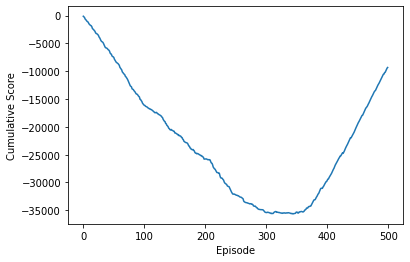

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

series = pd.Series(scores)
cumsum = series.cumsum()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(cumsum)), cumsum)
plt.ylabel('Cumulative Score')
plt.xlabel('Episode')
plt.show()

**agent's performance with DQN model and batch size of 64 is shown in part 2. above agent's performance with DDQN model is shown in the plot above. as it's seen the highest score in DDQN model is 204, meanwhile DQN model has a score of 166.29. this shows that DDQN perfroms better than DQN.**